# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.

Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

In [1]:
%pip install datasets
%pip install ipywidgets
%pip install transformers
%pip install sentencepiece sacremoses importlib_metadata

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

ds = load_dataset("stanfordnlp/imdb") # Large Movie Review Dataset from Hugging Face Hub
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased') # load bert model from github repo

Using cache found in /home/vmadmin/.cache/torch/hub/huggingface_pytorch-transformers_main
/home/vmadmin/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
def collate_fn(batch): # get texts and labels from a batch dataset
  max_len = 400
  texts, labels = [], []
  for row in batch:
    texts.append(row['text'])

  texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids) # bert tokenizer outputs input_ids index from bert vocabulary store.
  texts_dup = texts.clone()

  labels = []
  indx = []

  for id, text_dup in enumerate(texts_dup):
    indx = (text_dup == 102).nonzero(as_tuple=True)
    indx = indx[0].data.item()

    labels.append(text_dup[indx-1])
    texts[id][0] = 0
    texts[id][indx-1] = 0
    texts[id][indx] = 0


  labels = torch.LongTensor(labels) # 64bit integer tensor

  return texts, labels

BATCH_SIZE = 64

train_loader = DataLoader(
    ds['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    ds['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

In [4]:
iterdata = iter(train_loader)
text, label = next(iterdata)
print(text.shape), print(text) 
print(label.shape), print(label)

torch.Size([64, 400])
tensor([[    0,  2043, 13898,  ...,  6603,     0,     0],
        [    0,  1045,  2572,  ...,     0,     0,     0],
        [    0,  1045,  2064,  ...,     0,     0,     0],
        ...,
        [    0,  1045,  2228,  ...,  1999,     0,     0],
        [    0,  1045,  2196,  ...,  2339,     0,     0],
        [    0,  1012,  1012,  ...,     0,     0,     0]])
torch.Size([64])
tensor([ 2065,  1012,   999,  2836,  1012,  1012,   999,  1012,  1012,  1012,
         1012,  1012,  1012,  1023,  1012,   999,  1012,   999,  1012,  1012,
         9996,  1012,  1998,   999,  5024,  1012,  5136,  1012,  2619,  1012,
         1012,  1012,  1012,  1012,  1007,  1012,  1012,   999,  1012,  1012,
         1012,  1012,   999,   999,  1012,  2412,  1012,  2098,   999,  1012,
         2068,  2553,  1012, 11113,   999,  2184,  2077,  1012,  1012,  1051,
         1012,  1996,  2027,  1012])


(None, None)

## Multi-head attention

이번에는 self-attention을 구현해보겠습니다.

Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.

여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.

구현은 다음과 같습니다.

In [5]:
from torch import nn
from math import sqrt

# Multi-head attention
class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_head):
    super().__init__()
    assert d_model % n_head == 0, "d_model must be divisible by n_heads"

    self.input_dim = input_dim
    self.d_model = d_model 
    self.n_head = n_head 
    self.depth = d_model // n_head

    self.wq = nn.Linear(self.input_dim, self.d_model)
    self.wk = nn.Linear(self.input_dim, self.d_model)
    self.wv = nn.Linear(self.input_dim, self.d_model)
    self.dense = nn.Linear(self.d_model, self.d_model)

    self.softmax = nn.Softmax(dim=-1)
  
  def split_heads(self, x):
    batch_s = x.size(0)
    x = x.view(batch_s, -1, self.n_head, self.depth)
    return x.transpose(1, 2)

  def forward(self, x, mask):
    batch_s= x.size(0)
    q, k, v = self.wq(x), self.wk(x), self.wv(x)

    # split output of lenear transformation
    q = self.split_heads(q) 
    k = self.split_heads(k) 
    v = self.split_heads(v) 
    mask = mask.unsqueeze(1).expand(batch_s, self.n_head, -1, -1)

    # Scaled Dot-Product Attention
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, H, S, D') * (B, H, D, S') = (B, H, S, S)
    score = score / sqrt(self.depth) # scale the score to prevent vanishing gradient.

    if mask is not None:
      score = score + (mask * -1e9) # Mask

    score = self.softmax(score) 
    result = torch.matmul(score, v)

    # concat attentions  
    result = result.transpose(1,2).contiguous().view(batch_s, -1, self.d_model)

    result = self.dense(result)

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 multi-head attention과 feed-forward layer를 구현한 모습입니다.

In [6]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff
    self.n_head = 4

    self.sa = MultiHeadAttention(input_dim, d_model, self.n_head)

    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.LeakyReLU(),
      nn.Linear(dff, d_model)
    )

    self.dropout = nn.Dropout(0.1)
    self.norm = nn.LayerNorm(d_model)

  def forward(self, x, mask):
    x1 = self.sa(x, mask)
    x1 = self.dropout(x1)
    x = self.norm(x + x1)

    x1 = self.ffn(x)
    x1 = self.dropout(x1)
    x = self.norm(x + x1)

    return x

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [7]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400

Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [8]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, d_ffn):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.d_ffn = d_ffn

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, d_ffn) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size)

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:,0]
    x = self.classification(x)


    return x


model = TextClassifier(len(tokenizer), 32, 5, 32)

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [9]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [11]:
n_epochs = 50

train_acc = []
test_acc = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    
    loss = loss_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc.append(accuracy(model, train_loader))
    test_acc.append(accuracy(model, test_loader))
    print(f"=========> Train acc: {train_acc[-1]:.3f} | Test acc: {test_acc[-1]:.3f}")

Epoch   0 | Train Loss: 1580.3731536865234
=========> Train acc: 0.561 | Test acc: 0.566
Epoch   1 | Train Loss: 1102.8242069482803
=========> Train acc: 0.561 | Test acc: 0.566
Epoch   2 | Train Loss: 1045.8036987781525
=========> Train acc: 0.562 | Test acc: 0.563
Epoch   3 | Train Loss: 1016.5024868249893
=========> Train acc: 0.570 | Test acc: 0.560
Epoch   4 | Train Loss: 996.638640999794
=========> Train acc: 0.572 | Test acc: 0.565
Epoch   5 | Train Loss: 975.7339627742767
=========> Train acc: 0.576 | Test acc: 0.562
Epoch   6 | Train Loss: 954.554073214531
=========> Train acc: 0.578 | Test acc: 0.555
Epoch   7 | Train Loss: 931.492768406868
=========> Train acc: 0.584 | Test acc: 0.557
Epoch   8 | Train Loss: 909.9394272565842
=========> Train acc: 0.586 | Test acc: 0.537
Epoch   9 | Train Loss: 882.1081402301788
=========> Train acc: 0.597 | Test acc: 0.517
Epoch  10 | Train Loss: 854.5513195991516
=========> Train acc: 0.611 | Test acc: 0.533
Epoch  11 | Train Loss: 822.540

학습이 안정적으로 진행되며 RNN보다 빨리 수렴하는 것을 확인할 수 있습니다.

하지만 test 정확도가 RNN보다 낮은 것을 보았을 때, overfitting에 취약하다는 것을 알 수 있습니다.

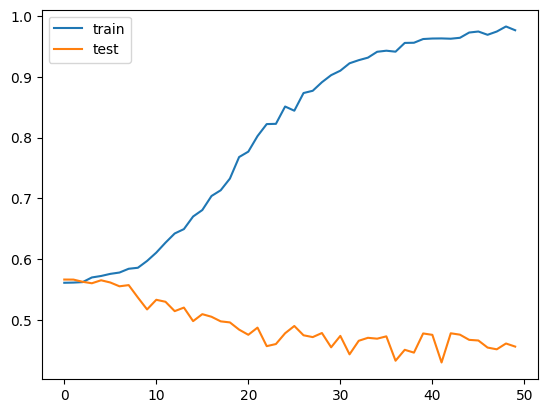

Max accuercy with train set: 98.256%
Max accuercy with test set: 56.647999999999996%


In [12]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_acc, test_acc)

print(f'Max accuercy with train set: {max(train_acc)*100.}%')
print(f'Max accuercy with test set: {max(test_acc)*100.}%')